# Learning to play Blackjack using Deep Reinforcement Learning
## Chris Durbin

Note that the inspiration and design of some of the driver, environment and agent code came from Dr. Happel's Reinforcement Learning Project 2 and Project 3 assignments.

I've been testing my code from the commandline and have the code in separate files, but to make it easier to submit and show all the code I'll paste in all of the files as individual cells in this notebook. First I will define cells for each of my agents.

### First-visit monte carlo agent

In [1]:
import numpy as np

def check_for_duplicates(trajectory, state, action):
    """Checks to see if there is another row in the provided trajectory for the
    same state and action. For the first visit Monte Carlo algorithm we only want
    to process the first visit."""
    for row in trajectory:
        if row['s'] == state and row['a'] == action:
            return True
    return False

class RlAgent:
    def __init__(self):
        self.num_states = 203 # Note that only 202 are actually reachable
        self.num_actions = 2
        self.actions = list(range(self.num_actions))
        self.state = None
        self.action = None
        self.epsilon = 0.15
        self.discount_factor = 1.0
        self.current_trajectory = []
        self.q = {}
        self.sa_visits = {}

    # Public API
    def get_number_of_states(self):
        return self.num_states

    def get_number_of_actions(self):
        return self.num_actions

    def select_action(self, state):
        if self.state is None:
            self.current_trajectory = [{'s': state}]
        self.state = state
        q_values = []
        for action in self.actions:
            key = self.get_state_action_pair_key(state, action)
            q_value = self.q.get(key, 0)
            q_values.append(q_value)

        action = self.e_greedy(q_values)
        self.action = action
        self.current_trajectory[-1]['a'] = action
        return action

    def get_state_action_pair_key(self, state, action):
        if isinstance(state, int):
            return (state,action)
        state_tuple = (state['agent_total'], state['usable_ace'], state['dealer_visible_total'], state['dealer_ace'], action)
        return state_tuple

    def learn(self, state, action, new_state, reward, game_end):
        """Update the q value using the first visit Monte Carlo control algorithm."""
        self.current_trajectory.append({'r': reward, 's': new_state})
        if game_end:
            self.replay_trajectory()
            self.current_trajectory = []
            self.action = None
            self.state = None
        else:
            self.state = new_state

    # Private API
    def e_greedy(self, q_values):
        """Implements epsilon greedy algorithm."""
        rng = np.random.default_rng()
        if self.epsilon <= rng.random():
            best_action_idx = np.argmax(q_values)
            return best_action_idx
        else:
            num_actions = len(q_values)
            idx = rng.integers(low=0, high=num_actions)
            return idx

    def replay_trajectory(self):
        """Replays the trajectory implementing the first visit Monte Carlo algorithm."""
        trajectory = self.current_trajectory
        trajectory.reverse() # process the trajectory backwards
        G = 0
        for i in range(len(trajectory) - 1):
            reward = trajectory[i]['r']
            G = self.discount_factor * G + reward
            # print(f'G is {G}')
            state = trajectory[i + 1]['s']
            action = trajectory[i + 1]['a']
            has_duplicate = False
            if i < len(trajectory) - 2:
                has_duplicate = check_for_duplicates(trajectory[i+2:], state, action)
            # print(f'Has duplicate is {has_duplicate}')
            if not has_duplicate:
                key = self.get_state_action_pair_key(state, action)
                q = self.q.get(key, 0)
                n = self.sa_visits.get(key, 1)
                self.sa_visits[key] = n + 1
                updated_q = q + ((G - q) / n)
                self.q[key] = updated_q


### Q-learning agent

In [2]:
import numpy as np

class QLearningAgent:
    def __init__(self, alpha=0.1, epsilon=0.2, gamma=0.9):
        self.num_states = 203 + 1
        self.num_actions = 2
        self.actions = list(range(self.num_actions))
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q = {}

    # Public API
    def get_number_of_states(self):
        return self.num_states

    def get_number_of_actions(self):
        return self.num_actions

    def select_action(self, state):
        # print(f'State is {state}')
        q_values = []
        for action in self.actions:
            key = self.get_state_action_pair_key(state, action)
            q_value = self.q.get(key, 0)
            q_values.append(q_value)
        action = self.e_greedy(q_values)

        return action

    def get_state_action_pair_key(self, state, action):
        if isinstance(state, int):
            return (state,action)
        state_tuple = (state['agent_total'], state['usable_ace'], state['dealer_visible_total'], state['dealer_ace'], action)
        return state_tuple

    def get_max_q_value(self, state):
        q_values = []
        for action in self.actions:
            key = self.get_state_action_pair_key(state, action)
            q_value = self.q.get(key, 0)
            q_values.append(q_value)
        return np.max(q_values)

    def learn(self, state, action, new_state, reward, game_end):
        """Update the q value using the Q-learning algorithm."""
        max_q = self.get_max_q_value(new_state)
        key = self.get_state_action_pair_key(state, action)
        current_q = self.q.get(key, 0)
        new_q_value = current_q + self.alpha * (reward + (self.gamma * max_q) - current_q)
        self.q[key] = new_q_value


    # Private API
    def e_greedy(self, q_values):
        """Implements epsilon greedy algorithm."""
        rng = np.random.default_rng()
        if self.epsilon <= rng.random():
            best_action_idx = np.argmax(q_values)
            return best_action_idx
        else:
            num_actions = len(q_values)
            idx = rng.integers(low=0, high=num_actions)
            return idx

### DQN agent

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, num_features, action_size, hidden_size):
        super(DQN, self).__init__()
        self.inputs = nn.Linear(num_features, hidden_size)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.outputs = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        # print(f'x is {x}')
        x = torch.FloatTensor(x)
        x = self.relu(self.inputs(x))
        x = self.relu(self.hidden(x))
        return self.outputs(x)

def state_to_inputs(state):
    if state is None:
        return [0, 0, 0, 0, 199]
    elif isinstance(state, int):
        return [0, 0, 0, 0, state]
    else:
        return [state['agent_total'], state['usable_ace'], state['dealer_visible_total'], state['dealer_ace'], 200]

class DQNAgent:
    def __init__(self):
        self.action_size=2
        self.replay_buffer_size=2000
        self.min_replay_size=50
        self.batch_size=32
        self.gamma=0.95
        self.epsilon=0.2
        self.epsilon_min=0.01
        self.epsilon_decay=0.995
        self.learning_rate=0.001
        self.memory = deque(maxlen=self.replay_buffer_size)
        self.num_features = 5
        self.hidden_size = 24
        self.model = DQN(self.num_features, self.action_size, self.hidden_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.device = 'cpu'

    def select_action(self, state):
        state_input = state_to_inputs(state)
        state_tensor = torch.FloatTensor([state_input]).to(torch.device(self.device))  # Adds batch dimension
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
        else:
            self.model.eval()
            with torch.no_grad():
                action_values = self.model(state_tensor)
            action = np.argmax(action_values.cpu().data.numpy())
            # Uncomment to test choosing the worst action as a sanity check the network is learning
            # action = np.argmin(action_values.cpu().data.numpy())
        return action

    def replay(self):
        if len(self.memory) < self.min_replay_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in minibatch:
            state_input = torch.FloatTensor([state_to_inputs(state)]).to(torch.device(self.device))
            next_state_input = torch.FloatTensor([state_to_inputs(next_state)]).to(torch.device(self.device))
            reward = torch.FloatTensor([reward]).to(torch.device(self.device))
            action = torch.LongTensor([action]).to(torch.device(self.device))

            Q_expected = self.model(state_input).gather(1, action.unsqueeze(-1)).squeeze(-1)
            Q_next = self.model(next_state_input).max(1)[0].detach()
            Q_target = reward + (self.gamma * Q_next)

            loss = self.criterion(Q_expected, Q_target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, state, action, new_state, reward, done):
        # print(f'Learn: State is {state}, new_state is {new_state}')
        self.memory.append((state, action, reward, new_state))
        self.replay()

### Blackjack environment

In [4]:
import random

SUITS = ['club', 'spade', 'heart', 'diamond']

class CardDeck:
    def __init__(self, number_of_decks=1):
        cards = []
        for i in range(2, 11): # Cards 2 through 10
            for suit in SUITS:
                card = { 'name': i, 'value': i, 'suit': suit }
                cards.append(card)

        # Add the aces
        for suit in SUITS:
            card = { 'name': 'ace', 'value': 1, 'suit': suit, 'alt_value': 11 }
            cards.append(card)

        # Add the other face cards
        for face_card in ['jack', 'queen', 'king']:
            for suit in SUITS:
                card = { 'name': face_card, 'value': 10, 'suit': suit }
                cards.append(card)

        self.cards = cards
        self.deal_seq = []
        self.number_of_decks = number_of_decks

    def shuffle_cards(self):
        self.deal_seq = random.sample(self.cards, 52 * self.number_of_decks)

    def deal_card(self):
        return self.deal_seq.pop(0)

class Blackjack:
    def __init__(self):

        self.deck = CardDeck()
        self.agent_total = 0
        self.usable_ace = 0
        self.dealer_visible_total = 0
        self.dealer_total = 0
        self.dealer_ace = 0
        self.current_state = None

    def get_state(self):
        return self.current_state

    def construct_state(self):
        state = {
            'agent_total': self.agent_total,
            'usable_ace': self.usable_ace,
            'dealer_visible_total': self.dealer_visible_total,
            'dealer_ace': self.dealer_ace
        }
        return state

    def get_next_state(self):
        new_card = self.deck.deal_card()
        self.agent_total += new_card['value']
        if self.agent_total > 21 and self.usable_ace == True:
            self.usable_ace = False
            self.agent_total -= 10
        # print("Agent drew a", new_card, "and now has", self.agent_total, "points.")
        if self.agent_total > 21:
            new_state = 201
        else:
            new_state = self.construct_state()
        return new_state

    def reset(self):
        self.deck.shuffle_cards()
        self.agent_total = 0
        self.usable_ace = False
        self.dealer_visible_total = 0
        self.dealer_total = 0
        self.dealer_ace = False
        self.current_state = None

        # deal a face up card and a second card to the dealer
        dealer_face_up_card = self.deck.deal_card()
        dealer_face_down_card = self.deck.deal_card()
        self.dealer_total = dealer_face_up_card['value'] + dealer_face_down_card['value']
        self.dealer_visible_total = dealer_face_up_card['value']
        if dealer_face_up_card['value'] == 1 or dealer_face_down_card['value'] == 1:
            self.dealer_ace = True
            self.dealer_total += 10
        # print("Dealer has", self.dealer_card, "and", dealer_face_down_card)
        # print("Dealer has", self.dealer_total, "points.")

        # deal two cards to the agent
        card_1 = self.deck.deal_card()
        card_2 = self.deck.deal_card()
        self.agent_total = card_1['value'] + card_2['value']
        if card_1['value'] == 1 or card_2['value'] == 1:
            self.usable_ace = True
            self.agent_total += 10
        # print("Agent has", card_1, "and", card_2)
        # print("Agent has", self.agent_total, "points.")

        # check to see if the agent has a natural (ace + face card)
        if self.agent_total == 21:
            # TBD - figure out what to do here since it will be important for bet size
            # But for now just shuffle again
            # self.reset()
            if self.dealer_total == 21:
                self.current_state = 202    # tie game
            else:
                self.current_state = 203    # agent wins

        # otherwise, deal enough cards to the agent so that the total is >11
        else:
            while self.agent_total < 12:
                new_card = self.deck.deal_card()
                self.agent_total += new_card['value']
                if new_card['value'] == 1 and self.usable_ace == False and self.agent_total < 12:
                    self.usable_ace = True
                    self.agent_total += 10
                # print("Agent drew a", new_card, "and now has", self.agent_total, "points.")
            # now determine the initial state
            self.current_state = self.construct_state()

        # reset complete; return the initial state
        return self.current_state

    # Use the agent's action to determine the next state and reward
    def execute_action(self, action):
        # action is 'stick'
        if action == 0:
            # dealer's turn
            while self.dealer_total < 17:
                new_card = self.deck.deal_card()
                self.dealer_total += new_card['value']
                if new_card['value'] == 1 and self.dealer_ace == 0 and self.dealer_total < 12:
                    self.dealer_ace = 1
                    self.agent_total += 10
                if self.dealer_total > 21 and self.dealer_ace == 1:
                    self.dealer_ace = 0
                    self.agent_total -= 10
            new_state = None
            if self.dealer_total > 21:
                # dealer busted; agent wins
                new_state = 203
                reward = 1
                game_end = True
            else:
                if self.dealer_total > self.agent_total:
                    # dealer wins
                    new_state = 201
                    reward = -1
                    game_end = True
                elif self.dealer_total < self.agent_total:
                    # agent wins
                    new_state = 203
                    reward = 1
                    game_end = True
                else:
                    # tie
                    new_state = 202
                    reward = 0
                    game_end = True

        # action is 'hit'
        elif action == 1:
            new_state = self.get_next_state()
            # if new_state == None:
            if new_state == 201:
                reward = -1
                game_end = True
            else:
                reward = 0
                game_end = False

        # print("new_state =", new_state, "reward = ", reward, "game_end =", game_end)
        self.current_state = new_state
        return new_state, reward, game_end

### Driver

In [5]:
import monte_carlo_agent
import q_learning_agent
import blackjack_env
import dqn_agent

import numpy as np
import os
import sys

# Usage: `python driver.py` to run the assignment as specified
# To run a different test scenario (described below) run `python driver.py <scenario number>`
def main(scenario=1, agent_type=1):
    print(f'Running scenario {scenario}')
    NUM_EPISODES = 2000
    NUM_AGENTS = 10
    agents_win_rates = []
    agents_win_rates_excluding_ties = []
    agents_cumulative_rewards = []
    if agent_type == 1:
        print('Using Monte Carlo agent')
    elif agent_type == 2:
        print('Using Q-learning agent')
    else:
        print('Using DQN agent')
    for a in range(NUM_AGENTS):
        agents_win_rates.append([])
        agents_win_rates_excluding_ties.append([])
        agents_cumulative_rewards.append([])
        environment = blackjack_env.Blackjack()
        if agent_type == 1:
            agent = monte_carlo_agent.RlAgent()
        elif agent_type == 2:
            agent = q_learning_agent.QLearningAgent()
        else:
            agent = dqn_agent.DQNAgent()
        wins = 0
        ties = 0
        cumulative_rewards = 0
        for i in range(NUM_EPISODES):
            # reset the game and observe the current state
            current_state = environment.reset()
            game_end = False
            # Do until the game ends:
            while not game_end:
                action = agent.select_action(current_state)
                # print(f'Action selected is {action}')
                new_state, reward, game_end = environment.execute_action(action)
                cumulative_rewards += reward
                agent.learn(current_state, action, new_state, reward, game_end)
                current_state = new_state
                if game_end:
                    if reward > 0:
                        wins += 1
                    elif reward == 0:
                        ties += 1
                    if scenario == 1:
                        agents_win_rates[a].append(wins / (i + 1.0))
                        agents_win_rates_excluding_ties[a].append(wins / max([1, (i + 1.0 - ties)]))
                        agents_cumulative_rewards[a].append(cumulative_rewards)
        if scenario == 1:
            print(f"Agent {a} Win rate: {wins / (NUM_EPISODES):.2f}, Win rate excluding ties: {wins / (NUM_EPISODES - ties):.2f}")
            print(f"Agent {a} Wins: {wins}, losses: {(NUM_EPISODES - ties - wins)}, ties: {ties}")

        # Exploit only
        if scenario == 2:
            wins = 0
            ties = 0
            agent.epsilon = 0.0
            for i in range(NUM_EPISODES):
                current_state = environment.reset()
                game_end = False
                while not game_end:
                    action = agent.select_action(current_state)
                    new_state, reward, game_end = environment.execute_action(action)
                    agent.learn(new_state, reward, game_end)
                    current_state = new_state
                    if game_end:
                        if reward > 0:
                            wins += 1
                        elif reward == 0:
                            ties += 1
                        agents_win_rates[a].append(wins / (i + 1.0))
                        agents_win_rates_excluding_ties[a].append(wins / max([1, (i + 1.0 - ties)]))
                        agents_cumulative_rewards[a].append(cumulative_rewards)
            print(f"Agent {a} win rate while exploiting and excluding ties: {wins / (NUM_EPISODES - ties):.2f}")
            print(f"Agent {a} wins: {wins}, losses: {(NUM_EPISODES - ties - wins)}, ties: {ties}\n")
    if scenario == 1 or scenario == 2:
        avg_win_rate = np.mean(agents_win_rates, axis=0)
        avg_win_rate_no_ties = np.mean(agents_win_rates_excluding_ties, axis=0)
        print(f'Mean win rate: {avg_win_rate[-1]:.2f}, Mean win rate excluding ties: {avg_win_rate_no_ties[-1]:.2f}')
    if scenario == 1:
        avg_cumulative_rewards = np.mean(agents_cumulative_rewards, axis=0)
        print(f'Mean cumulative rewards: {avg_cumulative_rewards[-1]:.1f}')

    # Save off the files to use for analysis and generating charts
    os.makedirs('output', exist_ok=True)
    np.save('output/agents_win_rates', agents_win_rates)
    np.save('output/agents_cumulative_rewards', agents_cumulative_rewards)
    print("Program completed successfully.")

# if __name__ == "__main__":
#     scenario = 1
#     if len(sys.argv) >= 2:
#         try:
#             scenario = int(sys.argv[1])
#             if scenario != 1 and scenario != 2:
#                 print(f"The passed in scenario number {scenario} is invalid, it must be 1 or 2.")
#                 exit(1)
#         except:
#             print("The passed in scenario must be an integer: 1 or 2.")
#             exit(1)

#     agent_type = 2
#     main(scenario, agent_type)

In [6]:
%%time

main(1, 1)

Running scenario 1
Using Monte Carlo agent
Agent 0 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 0 Wins: 807, losses: 1057, ties: 136
Agent 1 Win rate: 0.41, Win rate excluding ties: 0.44
Agent 1 Wins: 817, losses: 1030, ties: 153
Agent 2 Win rate: 0.43, Win rate excluding ties: 0.46
Agent 2 Wins: 856, losses: 988, ties: 156
Agent 3 Win rate: 0.43, Win rate excluding ties: 0.46
Agent 3 Wins: 862, losses: 1008, ties: 130
Agent 4 Win rate: 0.41, Win rate excluding ties: 0.44
Agent 4 Wins: 824, losses: 1057, ties: 119
Agent 5 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 5 Wins: 808, losses: 1052, ties: 140
Agent 6 Win rate: 0.39, Win rate excluding ties: 0.43
Agent 6 Wins: 788, losses: 1064, ties: 148
Agent 7 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 7 Wins: 800, losses: 1069, ties: 131
Agent 8 Win rate: 0.42, Win rate excluding ties: 0.44
Agent 8 Wins: 833, losses: 1054, ties: 113
Agent 9 Win rate: 0.41, Win rate excluding ties: 0.44
Agent 9 Wins: 827, losses: 1061

Plot the cumulative rewards for the Monte carlo agent

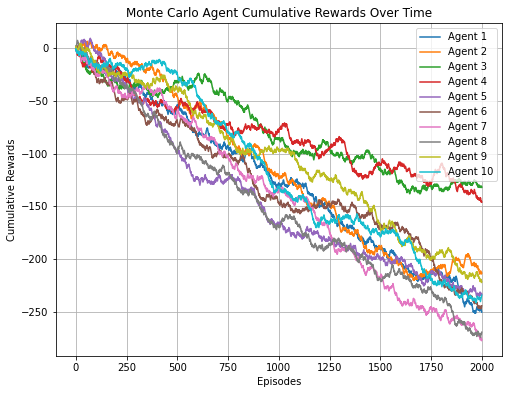

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
plt.figure(figsize=(8, 6))

agents_win_rates = np.load('output/agents_win_rates.npy')
agents_cumulative_rewards = np.load('output/agents_cumulative_rewards.npy')

for i in range(agents_cumulative_rewards.shape[0]):
    plt.plot(agents_cumulative_rewards[i], label=f'Agent {i+1}')

plt.title('Monte Carlo Agent Cumulative Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [8]:
%%time

main(1, 2)

Running scenario 1
Using Q-learning agent
Agent 0 Win rate: 0.42, Win rate excluding ties: 0.45
Agent 0 Wins: 834, losses: 1024, ties: 142
Agent 1 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 1 Wins: 792, losses: 1036, ties: 172
Agent 2 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 2 Wins: 807, losses: 1051, ties: 142
Agent 3 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 3 Wins: 805, losses: 1066, ties: 129
Agent 4 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 4 Wins: 797, losses: 1060, ties: 143
Agent 5 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 5 Wins: 801, losses: 1049, ties: 150
Agent 6 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 6 Wins: 793, losses: 1067, ties: 140
Agent 7 Win rate: 0.40, Win rate excluding ties: 0.43
Agent 7 Wins: 803, losses: 1053, ties: 144
Agent 8 Win rate: 0.42, Win rate excluding ties: 0.45
Agent 8 Wins: 848, losses: 1030, ties: 122
Agent 9 Win rate: 0.41, Win rate excluding ties: 0.45
Agent 9 Wins: 825, losses: 1024

Plot the cumulative rewards for the Q-learning agent

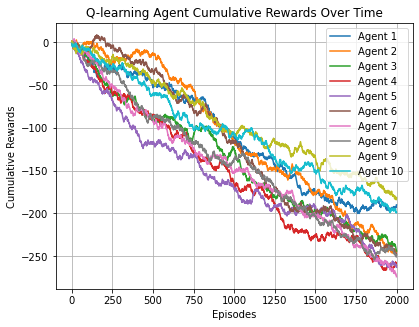

In [9]:
agents_win_rates = np.load('output/agents_win_rates.npy')
agents_cumulative_rewards = np.load('output/agents_cumulative_rewards.npy')

for i in range(agents_cumulative_rewards.shape[0]):
    plt.plot(agents_cumulative_rewards[i], label=f'Agent {i+1}')

plt.title('Q-learning Agent Cumulative Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [10]:
%%time

main(1, 3)

Running scenario 1
Using DQN agent
Agent 0 Win rate: 0.42, Win rate excluding ties: 0.45
Agent 0 Wins: 843, losses: 1020, ties: 137
Agent 1 Win rate: 0.43, Win rate excluding ties: 0.46
Agent 1 Wins: 865, losses: 997, ties: 138
Agent 2 Win rate: 0.42, Win rate excluding ties: 0.44
Agent 2 Wins: 831, losses: 1042, ties: 127
Agent 3 Win rate: 0.41, Win rate excluding ties: 0.44
Agent 3 Wins: 823, losses: 1032, ties: 145
Agent 4 Win rate: 0.43, Win rate excluding ties: 0.45
Agent 4 Wins: 857, losses: 1028, ties: 115
Agent 5 Win rate: 0.45, Win rate excluding ties: 0.48
Agent 5 Wins: 894, losses: 972, ties: 134
Agent 6 Win rate: 0.41, Win rate excluding ties: 0.43
Agent 6 Wins: 818, losses: 1063, ties: 119
Agent 7 Win rate: 0.43, Win rate excluding ties: 0.46
Agent 7 Wins: 861, losses: 1025, ties: 114
Agent 8 Win rate: 0.43, Win rate excluding ties: 0.45
Agent 8 Wins: 851, losses: 1023, ties: 126
Agent 9 Win rate: 0.42, Win rate excluding ties: 0.45
Agent 9 Wins: 840, losses: 1032, ties: 1

Plot the cumulative rewards for the DQN agent

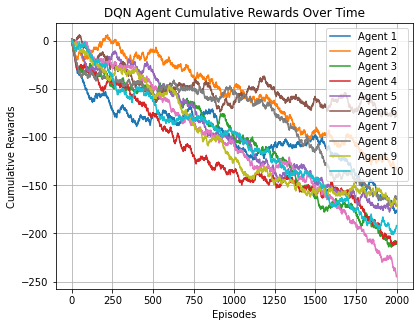

In [11]:
agents_win_rates = np.load('output/agents_win_rates.npy')
agents_cumulative_rewards = np.load('output/agents_cumulative_rewards.npy')

for i in range(agents_cumulative_rewards.shape[0]):
    plt.plot(agents_cumulative_rewards[i], label=f'Agent {i+1}')

plt.title('DQN Agent Cumulative Rewards Over Time')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()